In [1]:
import warnings
from pandas import Series
import pandas as pd
import numpy as np
import collections

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import recall_score, precision_score, f1_score, log_loss
from sklearn.metrics import accuracy_score


import matplotlib
pltmutual.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

warnings.filterwarnings("ignore")  # Убирает некритические сообщения
from sklearn.linear_model import LogisticRegressionCV

NameError: name 'pltmutual' is not defined

In [2]:
# read data
train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
test= pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')
sample_submission = pd.read_csv('/kaggle/input/sf-dst-scoring/sample_submission.csv')

In [3]:
# put all data into one data set and makt target in train and validation dataset
train['Sample'] = 1 
test['Sample'] = 0 
data = test.append(train, sort=False).reset_index(drop=True)

# data description
client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

# **first check**

In [4]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,Sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,NaN
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,NaN
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,NaN
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,NaN
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,NaN


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
client_id,110148.0,55074.500000,31797.133063,1.000000,27537.750000,55074.500000,82611.250000,110148.000000
age,110148.0,39.249410,11.518063,21.000000,30.000000,37.000000,48.000000,72.000000
decline_app_cnt,110148.0,0.273205,0.799099,0.000000,0.000000,0.000000,0.000000,33.000000
good_work,110148.0,0.165514,0.371645,0.000000,0.000000,0.000000,0.000000,1.000000
score_bki,110148.0,-1.904535,0.499397,-3.624586,-2.260434,-1.920823,-1.567888,0.199773
bki_request_cnt,110148.0,2.005002,2.266926,0.000000,0.000000,1.000000,3.000000,53.000000
region_rating,110148.0,56.751189,13.065923,20.000000,50.000000,50.000000,60.000000,80.000000
home_address,110148.0,1.574945,0.527562,1.000000,1.000000,2.000000,2.000000,3.000000
work_address,110148.0,2.497867,0.687651,1.000000,2.000000,3.000000,3.000000,3.000000
income,110148.0,41012.648537,45399.735051,1000.000000,20000.000000,30000.000000,48000.000000,1000000.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [7]:
data.isnull().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
Sample                  0
default             36349
dtype: int64

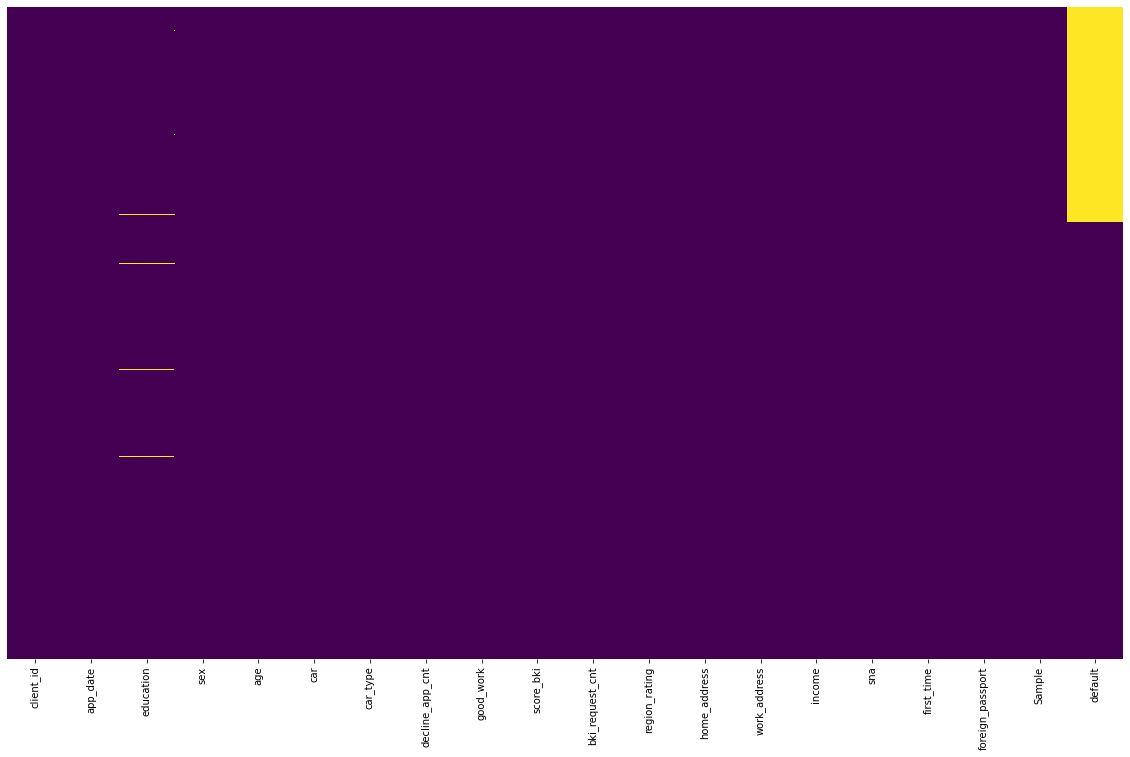

In [8]:
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

## COMMENTS:
dataset contains:
- binary/numeric/categorical/datetime feautres -> recode/prepare for modeling with LabelEncoder & OneHotEncoder
- education contain NaN's -> see how to deal with them

# 1. Preprocessing data
## 1.1 split features into numeric/categorical & binary

In [9]:
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'home_address', 'work_address', 'region_rating', 'sna', 'first_time', ]
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki']
date_cols = ['app_date']

> ****
# 1.1 target

In [10]:
data.default.value_counts(normalize=True)

0.0    0.873006
1.0    0.126994
Name: default, dtype: float64

<AxesSubplot:xlabel='default', ylabel='count'>

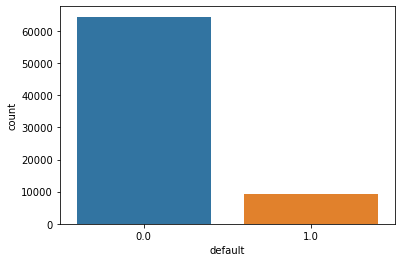

In [11]:
sns.countplot(x='default', data=data)

### COMMENT:
as we can see, the target destribution is unbalanced. 
* -> accuracy is not a good choice to check the model quality
* -> precision, recall, roc-auc & f1-score!

# 1.2 categorical features
## 1.2.1 education
- education fillna with most common value
- OneHotEncoding for categorical features

In [12]:
#check values frequency and replace Nan's
data.education.value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

<AxesSubplot:>

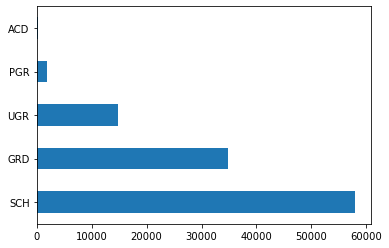

In [13]:
data['education'].value_counts().plot.barh()

SCH education level is most common value 
* -> put missing to SCH
* -> check default distibution within education levels

<AxesSubplot:xlabel='education', ylabel='count'>

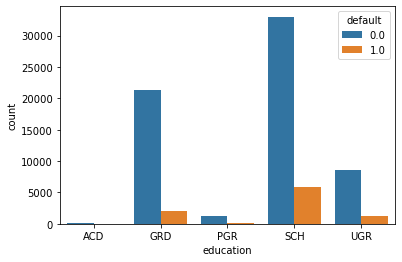

In [14]:
 sns.barplot(x="education", 
                 y="count",
                 hue="default",
                 data=data.groupby(['education', 'default'])['education'].count().reset_index(name='count'))

### COMMENT:
as we can see, there are some differences in education level for default and non-default client! 
it make sence to take this feature into the model

## 1.2.2 home address / work address

<AxesSubplot:xlabel='home_address', ylabel='count'>

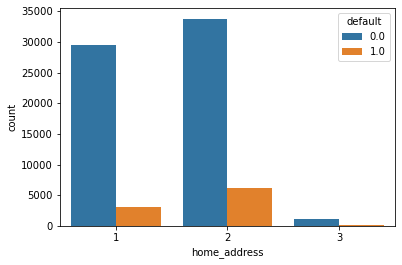

In [15]:
sns.barplot(x="home_address", 
                 y="count",
                 hue="default",
                 data=data.groupby(['home_address', 'default'])['home_address'].count().reset_index(name='count'))

<AxesSubplot:xlabel='work_address', ylabel='count'>

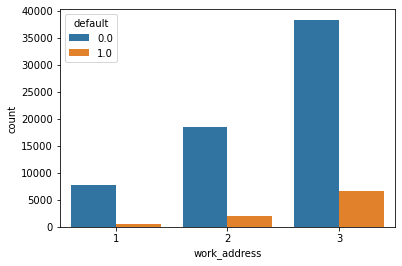

In [16]:
sns.barplot(x="work_address", 
                 y="count",
                 hue="default",
                 data=data.groupby(['work_address', 'default'])['work_address'].count().reset_index(name='count'))

### COMMENT:
- the figures above shows that campared to home_addreess default clients have higher work_address flag 
- check correlation between both features and correlation with target feature. maybe it make sense to drop one of them to avoid multicollinearity 

## 1.2.3 region rating

<AxesSubplot:xlabel='region_rating', ylabel='count'>

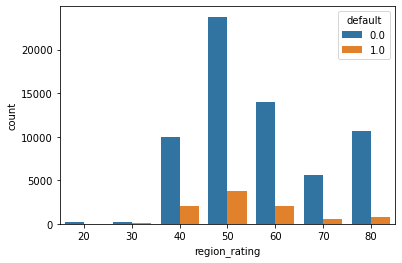

In [17]:
sns.barplot(x="region_rating", 
                 y="count",
                 hue="default",
                 data=data.groupby(['region_rating', 'default'])['region_rating'].count().reset_index(name='count'))

### COMMENT:
very low number of cases for region rating between 20 and 30. We can see that the region rating by default and non default client changing in the same direction
## 1.2.4 sna

<AxesSubplot:xlabel='sna', ylabel='count'>

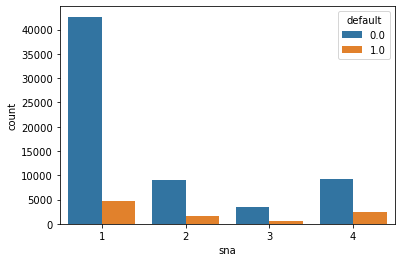

In [18]:
sns.barplot(x="sna", 
                 y="count",
                 hue="default",
                 data=data.groupby(['sna', 'default'])['sna'].count().reset_index(name='count'))

### COMMENT:
look very similar to region rating. default and non default client are changing in the same direction. The higherst number of contact with bank custimers lies by 1.
## 1.2.5 first time

<AxesSubplot:xlabel='first_time', ylabel='count'>

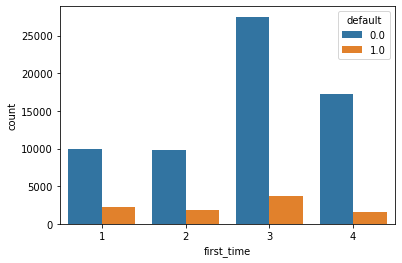

In [19]:
sns.barplot(x="first_time", 
                 y="count",
                 hue="default",
                 data=data.groupby(['first_time', 'default'])['first_time'].count().reset_index(name='count'))

### COMMETS:
the highest number of information about the bank clients lies by 3 both for default and non default clients

## 1.3 numerical columns
### 1.3.1 overview

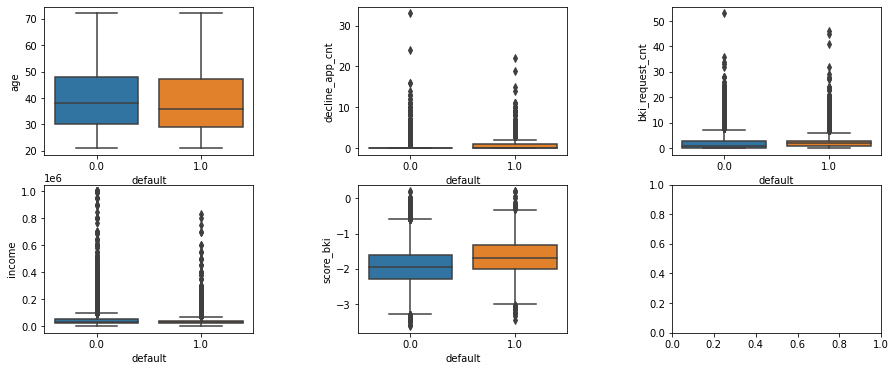

In [20]:
fig, axes = plt.subplots(2,3, figsize=(15,6))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()

for i in range(len(num_cols)):
    sns.boxplot(x='default', y=num_cols[i], data=data, orient='v', ax=axes[i])

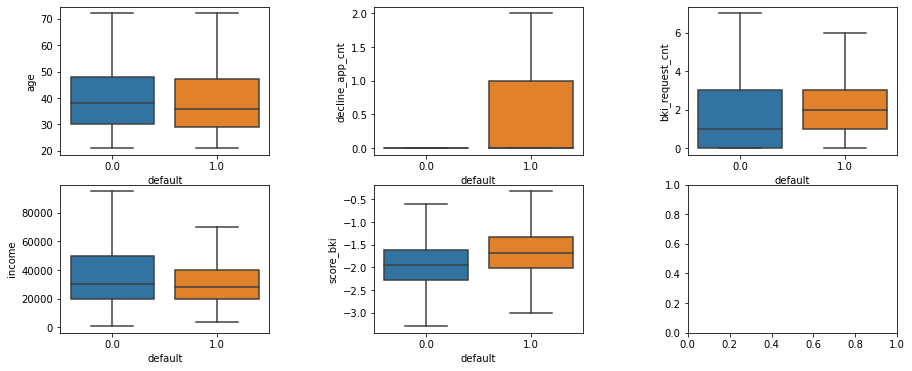

In [21]:
fig, axes = plt.subplots(2,3, figsize=(15,6))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()

for i in range(len(num_cols)):
    sns.boxplot(x='default', y=num_cols[i], data=data, orient='v', ax=axes[i], showfliers=False)


### COMMENT:
- the first figure shows that only age feature has no outliers, all other features have outliers
- AGE: there are not much differences berween default and non default client in age category. default clients are a little big younger
- DECLINE_APP_CNT: default clients have higher number of rejected applications in past
- default clints have higher number of bki request, lower salary and higher bki score. 

- -> check outliers for following features: 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki'
- -> first idea is to build the logarithm of features and check outliers again



In [22]:
#build function to build log of numeric features
cols_with_outliers =['decline_app_cnt', 'bki_request_cnt', 'income']
def log_func(df):
    for col in cols_with_outliers:
        df[col] = np.log(df[col] + 1)
    return df

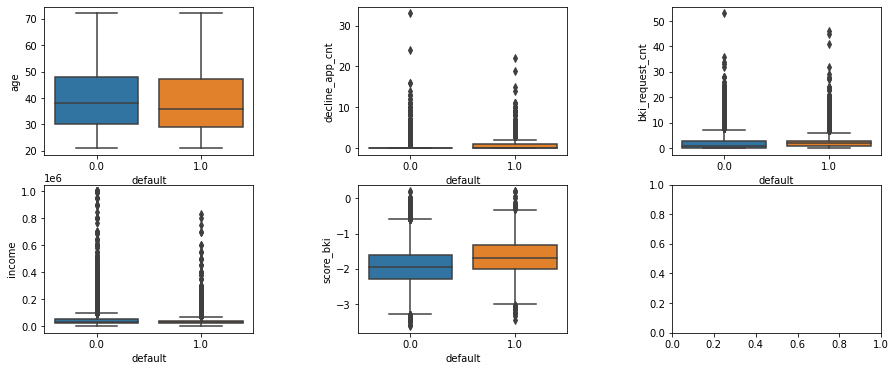

In [23]:
fig, axes = plt.subplots(2,3, figsize=(15,6))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()

for i in range(len(num_cols)):
    sns.boxplot(x='default', y=num_cols[i], data=data, orient='v', ax=axes[i])

### COMMENT:
logarithm helped, but the data still have outliers
* delete outliers from score_bki and decline_app_cnt



In [24]:
train = data[data['Sample']==1]
test = data[data['Sample']==0]
# delete outliers
outl_cols = ['bki_request_cnt', 'score_bki']
for i in outl_cols:
    q1 = data[i].quantile(0.75)
    q3 = data[i].quantile(0.25)
    iqr = q1-q3
    train = train[(train[i] <= q1+1.5*iqr) & (train[i] >= q3-1.5*iqr)]

data = pd.concat([train, test], )

### 1.4 binary features

<AxesSubplot:xlabel='sex', ylabel='count'>

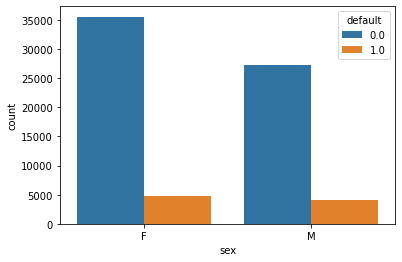

In [25]:
sns.barplot(x="sex", 
                 y="count",
                 hue="default",
                 data=data.groupby(['sex', 'default'])['sex'].count().reset_index(name='count'))

<AxesSubplot:xlabel='car', ylabel='count'>

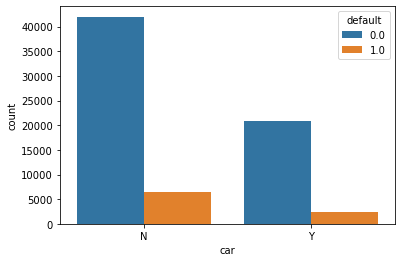

In [26]:
sns.barplot(x="car", 
                 y="count",
                 hue="default",
                 data=data.groupby(['car', 'default'])['car'].count().reset_index(name='count'))

<AxesSubplot:xlabel='car_type', ylabel='count'>

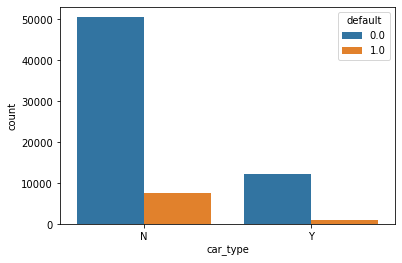

In [27]:
sns.barplot(x="car_type", 
                 y="count",
                 hue="default",
                 data=data.groupby(['car_type', 'default'])['car_type'].count().reset_index(name='count'))

<AxesSubplot:xlabel='foreign_passport', ylabel='count'>

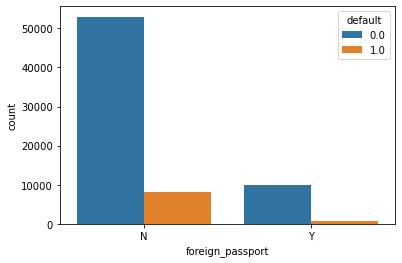

In [28]:
sns.barplot(x="foreign_passport", 
                 y="count",
                 hue="default",
                 data=data.groupby(['foreign_passport', 'default'])['foreign_passport'].count().reset_index(name='count'))

<AxesSubplot:xlabel='good_work', ylabel='count'>

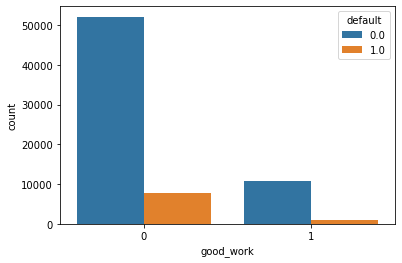

In [29]:
sns.barplot(x="good_work", 
                 y="count",
                 hue="default",
                 data=data.groupby(['good_work', 'default'])['good_work'].count().reset_index(name='count'))

### COMMENT:
* we can consider the differences in distribution for all binary variables in each client group (default and non default)
* we will take all binary variables into the model, but we have to tranform all categorical and binary features into numeric features

## 1.5 transform features to numeric

In [30]:
# for binary features we will use LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
#education
data['education'] = label_encoder.fit_transform(data['education'])
# check the trandformation

data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,Sample,default
36349,25905,01FEB2014,3,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,1,0.0
36350,63161,12MAR2014,3,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,1,0.0
36351,25887,01FEB2014,3,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,1,0.0
36352,16222,23JAN2014,3,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,1,0.0
36353,101655,18APR2014,1,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,1,0.0


## 1.6 app_date

In [31]:
# trainsform app_date to date fromat
data['app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,Sample,default
36349,25905,2014-02-01,3,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,1,0.0
36350,63161,2014-03-12,3,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,1,0.0
36351,25887,2014-02-01,3,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,1,0.0
36352,16222,2014-01-23,3,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,1,0.0
36353,101655,2014-04-18,1,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,1,0.0


In [32]:
#create new features: month, day, weekday and check the distibution
data['month'] = data.app_date.dt.month
data['weekday'] = data.app_date.dt.weekday # Monday 0 and Sunday 6
data['day'] = data.app_date.dt.day # Monday 0 and Sunday 6

<AxesSubplot:xlabel='month', ylabel='count'>

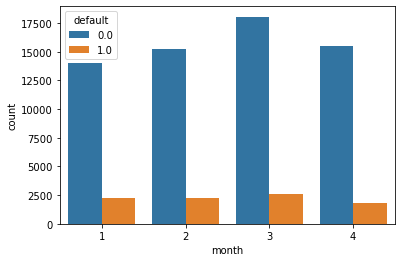

In [33]:
sns.barplot(x="month", 
                 y="count",
                 hue="default",
                 data=data.groupby(['month', 'default'])['month'].count().reset_index(name='count'))

### COMMENT: 
* we csn consider that in march we had more non default clients campared to other month

<AxesSubplot:xlabel='weekday', ylabel='count'>

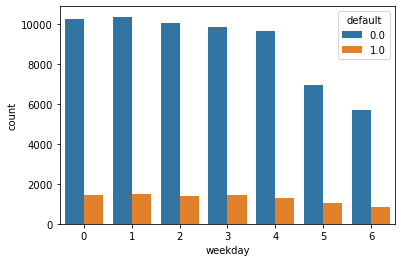

In [34]:
sns.barplot(x="weekday", 
                 y="count",
                 hue="default",
                 data=data.groupby(['weekday', 'default'])['weekday'].count().reset_index(name='count'))

### COMMENT:
* on the weekend we have les non default cases compared to work days
* we will include new features (month and weekday) to the model

<AxesSubplot:xlabel='day', ylabel='count'>

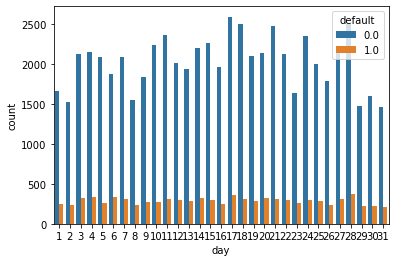

In [35]:
sns.barplot(x="day", 
                 y="count",
                 hue="default",
                 data=data.groupby(['day', 'default'])['day'].count().reset_index(name='count'))

### COMMENT:
* we can also consuder some flustuation between the days
-> will take the new feature into the model

In [36]:
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'home_address', 'work_address', 'region_rating', 'sna', 'first_time', 'weekday', 'month', 'day']
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki']
date_cols = ['app_date']

## 1.7 check correlation

<AxesSubplot:>

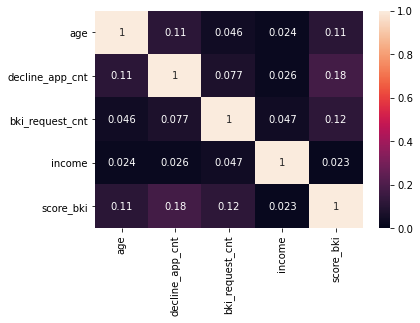

In [37]:
train = data[data['Sample']==1]
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1,  annot=True)

### COMMENT:
as we can see on the heatmap there aren't high correlations between the features, that means we don't have multicollinearity. 
* use mution information to check the dependencies between target variable and features

In [38]:
#replay NaN's with most common value
data['education'] = data.education.fillna('SCH')

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108098 entries, 36349 to 36348
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         108098 non-null  int64         
 1   app_date          108098 non-null  datetime64[ns]
 2   education         108098 non-null  int64         
 3   sex               108098 non-null  int64         
 4   age               108098 non-null  int64         
 5   car               108098 non-null  int64         
 6   car_type          108098 non-null  int64         
 7   decline_app_cnt   108098 non-null  int64         
 8   good_work         108098 non-null  int64         
 9   score_bki         108098 non-null  float64       
 10  bki_request_cnt   108098 non-null  int64         
 11  region_rating     108098 non-null  int64         
 12  home_address      108098 non-null  int64         
 13  work_address      108098 non-null  int64         
 14  i

<AxesSubplot:>

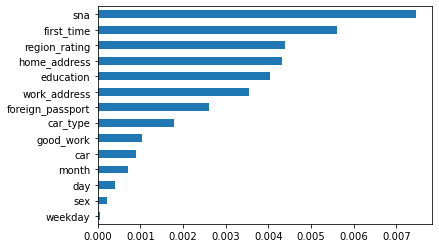

In [40]:
mi_score = Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'],
                                     discrete_features=True), index=bin_cols + cat_cols)
mi_score.sort_values(inplace=True)
mi_score.plot(kind='barh')

## prepare data for modelling

In [41]:
#label encoding of categorical & binary features
def label_encoding_func(df):
    label_encoder = LabelEncoder()
    for column in bin_cols + ['education']:
        df[column] = label_encoder.fit_transform(df[column])
    return df

#one hot encoding for categorical festures
def oh_encoder(df):
    X_cat = OneHotEncoder(sparse = False).fit_transform(df[cat_cols].values)
    return X_cat

#standardize numerical features
def standardize_data(df):
    X_num = StandardScaler().fit_transform(df[num_cols].values)
    return X_num



In [42]:
#apply all function to dataset
def prepare_data(df):
    df_encoded = label_encoding_func(df)
    X_cat = oh_encoder(df)
    X_num = standardize_data(df)
    X_bin = df_encoded[bin_cols].values
    return np.hstack([X_num, X_bin, X_cat])


## Split data: train / test 

In [43]:
train = data[data['Sample'] == 1]
test = data[data['Sample'] == 0]

#split data into test and validation datasets
X = train.drop(['default'], axis=1)
y = data[data['Sample']==1]['default']


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state=42)

#prepare data for modeling
X_train = prepare_data(X_train)
X_valid = prepare_data(X_valid)
X_test = prepare_data(test)

print('X_train shape:',  X_train.shape)
print('X_valid shape:',  X_valid.shape)
print('X_test shape:',  X_test.shape)

print('y_valid shape:',  y_valid.shape)
print('y_train shape:',  y_train.shape)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

X_train shape: (50224, 79)
X_valid shape: (21525, 79)
X_test shape: (36349, 79)
y_valid shape: (21525,)
y_train shape: (50224,)


# 1.9 Modelling
## 1.9.1 standart settings

In [44]:
#train the model
model = LogisticRegression(random_state=42, max_iter = 1000)
#fit the model
model.fit(X_train, y_train)
#build predictions
y_pred_proba = model.predict_proba(X_valid)[:,1]
y_pred = model.predict(X_valid)

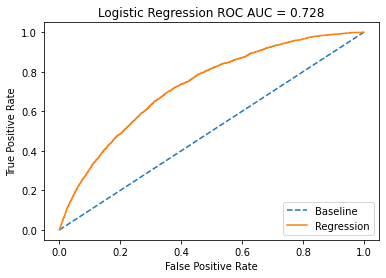

In [45]:
#build ROC-AUC plot to check model quality
fpr, tpr, threshold = roc_curve(y_valid, y_pred_proba)
roc_auc = roc_auc_score(y_valid, y_pred_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

### COMMENT:
ROC-AUC score lies by 73.4%. Seems to a good astimation, but as we saw earlier target variable is not balanced!
- -> check confusion matrix, to check how many true positive values predict the model

# confusion matrix
to check true positive and false positive rate

In [46]:
#model = LogisticRegressionCV(Cs=10, cv=20, penalty='l2' ,random_state=42, max_iter = 1000)

model_fit = model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_valid)[:,1]
y_pred = model.predict(X_valid)

In [47]:
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
print(tp, fp) 
print(fn, tn)

52 89
2613 18771


### COMMENT:
only 69 client were predicted correct. 2711 clients default clients were predicted as non default. We have to minimize this value

# 1.9.2 Hyperparameter tuning with GridSearch

In [48]:
#parameter settings
model = LogisticRegression(random_state=42)

stop = 0.001
max_interations = 70
l1_ratios_list = [0.1, 0.3, 0.5, 0.7, 0.9]

param_grid = [
     {'penalty': ['l1'],
      'solver': ['newton-cg', 'liblinear', 'lbfgs', 'sag', 'saga'],
      'class_weight':['none', 'balanced'],
      'multi_class': ['auto','ovr'],
      'max_iter': [max_interations],
      'tol':[stop]},
     {'penalty': ['l2'],
      'solver': ['newton-cg', 'lbfgs', 'sag'],
      'class_weight':['none', 'balanced'],
      'multi_class': ['auto','ovr'],
      'tol':[stop]},
     {'penalty': ['none'],
      'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
      'class_weight':['none', 'balanced'],
      'multi_class': ['auto','ovr'],
      'tol':[stop]},
    {'penalty': ['elasticnet'],
      'l1_ratio': [l1_ratios_list],
      'class_weight':['none', 'balanced'],
      'solver': ['saga'],
      'multi_class': ['auto','ovr'],
      'tol':[stop]}
        ]
      
gridsearch = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
 ## print best parameters
best_parameters = model.get_params()

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.73248342        nan
        nan        nan        nan 0.73248342        nan 0.73271496
        nan        nan 0.73272728        nan 0.73271496        nan
        nan 0.73272728 0.73239891 0.73241783 0.73240225 0.73239891
 0.73241783 0.73240225 0.73265416 0.73265177 0.73265556 0.73265416
 0.73265177 0.73265556 0.73236789 0.7323659  0.7323724  0.73238375
 0.73236789 0.7323659  0.7323724  0.73238375 0.73264267 0.73263962
 0.73264375 0.73264789 0.73264267 0.73263962 0.73264375 0.73264789
        nan        nan        nan        nan]
  category=UserWarning
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [49]:
# get best partameters
best_parameters

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 70,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 42,
 'solver': 'saga',
 'tol': 0.001,
 'verbose': 0,
 'warm_start': False}

In [50]:
# fit the model with best parameters 
model = LogisticRegression(random_state=42, 
                           C=1, 
                           class_weight='balanced', 
                           dual=False, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           l1_ratio=None, 
                           max_iter=70,
                           multi_class='auto', 
                           n_jobs=None, 
                           penalty='l1', 
                           solver='liblinear', 
                           verbose=0, 
                           tol=0.001,
                           warm_start=False)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_valid)[:,1]
y_pred = model.predict(X_valid)

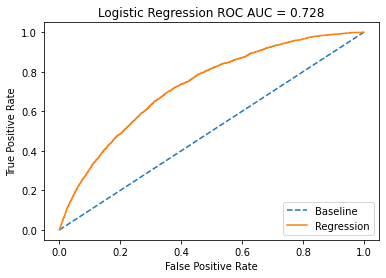

In [51]:
#build ROC-AUC plot to check model quality
fpr, tpr, threshold = roc_curve(y_valid, y_pred_proba)
roc_auc = roc_auc_score(y_valid, y_pred_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [52]:
best_parameters = model.get_params()
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

preds = model.predict(X_valid)
print('Accuracy: %.4f' % accuracy_score(y_valid, preds))
print('Precision: %.4f' % precision_score(y_valid, preds))
print('Recall: %.4f' % recall_score(y_valid, preds))
print('F1: %.4f' % f1_score(y_valid, preds))

	C: 1
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 70
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l1'
	random_state: 42
	solver: 'liblinear'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6683
Precision: 0.2225
Recall: 0.6732
F1: 0.3345


In [53]:
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
print(tp, fp) 
print(fn, tn)

1794 6269
871 12591


### COMMENT:
the results are looking much better.
* build test predictions for competition

# submit to competition


In [54]:
predict_submission = model.predict_proba(X_test)[:,1]

submit = pd.DataFrame(test.client_id)
submit['default']=predict_submission
submit.to_csv('submission.csv', index=False)
display(submit.head(10))

,client_id,default
0,74835,0.199504
1,17527,0.747545
2,75683,0.365695
3,26883,0.415372
4,28862,0.164878
5,99881,0.564084
6,26630,0.796507
7,79934,0.212587
8,16605,0.153296
9,105449,0.126107


In [55]:
submit.shape

(36349, 2)